<a href="https://colab.research.google.com/github/haedal-uni/analysis/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

주식 데이터(시가, 고가, 저가) 기반으로 주식의 종가를 예측하는 딥러닝 모델을 구축하고 학습시키는 코드다.

이 모델은 RNN(Recurrent Neural Network),

즉 순환 신경망을 사용하여 시간에 따라 변하는 데이터(주식 가격)에서 패턴을 학습하고 예측을 수행한다.  

https://wikidocs.net/223722

위 링크를 보고 함

<br>

'시퀀스'는 연속적인 요소들의 나열을 의미한다.

이 요소들은 특정한 순서를 가지고 있다.


In [ ]:
import warnings
import matplotlib
import sys

warnings.filterwarnings(action='ignore')

if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import pandas as pd
df = pd.read_csv('구리 선물 과거 데이터.csv', parse_dates=['날짜'], index_col="날짜", thousands=",") # 구분자 제거
df = df.sort_index()
df.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2015-01-30,2.4955,2.4350,2.5140,2.4350,0.15K,1.67%
2015-02-02,2.4925,2.4745,2.5145,2.4720,0.06K,-0.12%
2015-02-03,2.5830,2.5090,2.5950,2.5090,0.23K,3.63%
2015-02-04,2.5915,2.5795,2.6125,2.5600,0.31K,0.33%
2015-02-05,2.5960,2.5935,2.6040,2.5405,0.15K,0.17%


In [ ]:
df.tail()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2025-03-28,5.1300,5.1195,5.1675,5.0620,51.75K,0.62%
2025-03-31,5.0340,5.1300,5.1460,4.9850,53.78K,-1.87%
2025-04-01,5.0350,5.0550,5.1155,5.0045,49.68K,0.02%
2025-04-02,5.0405,5.0295,5.1450,4.9850,46.22K,0.11%
2025-04-03,4.8805,4.9178,4.9410,4.8658,19.44K,-3.17%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2643 entries, 2015-01-30 to 2025-04-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      2643 non-null   float64
 1   시가      2643 non-null   float64
 2   고가      2643 non-null   float64
 3   저가      2643 non-null   float64
 4   거래량     2562 non-null   object 
 5   변동 %    2643 non-null   object 
dtypes: float64(4), object(2)
memory usage: 144.5+ KB


인공지능이 주가의 변동 추이를 분석해

다음날의 종가를 예측하기를 원하므로

입력 데이터로는 개장가, 최고가, 최저가를 사용하고

정답 데이터로는 종가만 사용

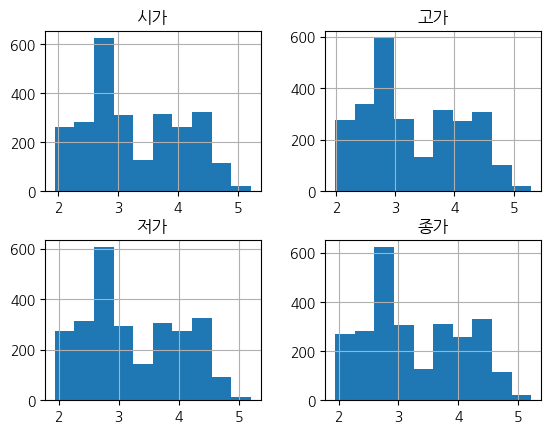

In [ ]:
import matplotlib.pyplot as plt

data_used = df.iloc[:, 1:4]  # 시가, 고가, 저가
data_used["종가"] = df["종가"]  # 종가
hist = data_used.hist()
plt.show()


In [ ]:
df.describe()

,종가,시가,고가,저가
count,2643.000000,2643.000000,2643.000000,2643.000000
mean,3.280174,3.279447,3.311406,3.248011
std,0.801491,0.800961,0.811969,0.790830
min,1.943500,1.938500,1.980000,1.935500
25%,2.635000,2.637000,2.659750,2.615500
50%,3.073000,3.074000,3.095500,3.052000
75%,4.031500,4.032750,4.075250,3.992250
max,5.218500,5.217000,5.298500,5.204000


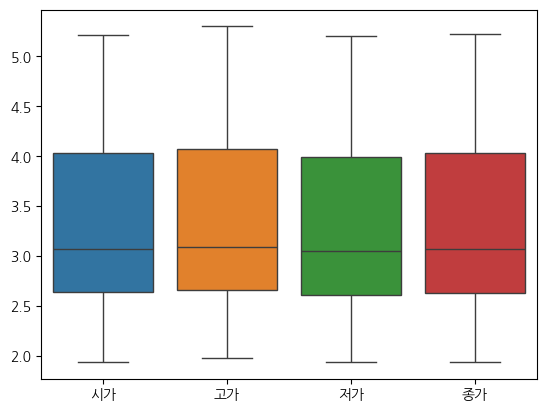

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.adam import Adam
import tqdm

# 박스플롯으로 이상치 확인
sns.boxplot(data=df[['시가', '고가', '저가', '종가']])
plt.show()

이상치나 각 컬럼들의 범위가 넓지 않아 정규화를 진행하지 않고 실행했다.

optim = Adam(...)

- 파라미터를 바꿔가며

- 오차가 줄어들도록

- 학습을 도와주는 역할

epoch199 loss:0.10736428201198578: 100%|██████████| 82/82 [00:01<00:00, 43.16it/s]


Total Loss: 0.016872864216566086
R² Score: 0.9738


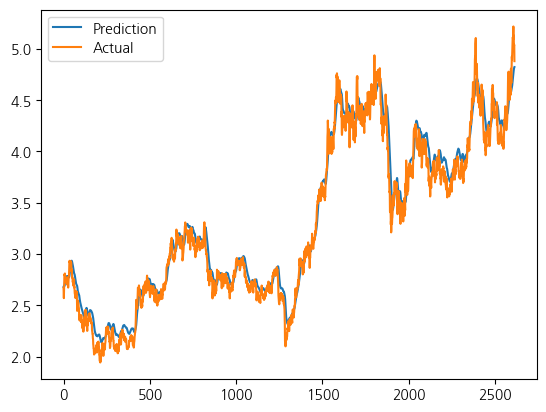

In [ ]:
from sklearn.metrics import r2_score

# 데이터셋 준비
class Cu(Dataset):  # 학습용 데이터 준비
    def __init__(self):
        # df 데이터 사용
        self.data = df[['시가', '고가', '저가']].values  # 입력 : 3가지
        self.label = df['종가'].values  # 정답 : 종가

    # 사용 가능한 데이터 개수
    def __len__(self):
        return len(self.data) - 30  # 사용 가능한 배치 개수

    # 데이터와 라벨 반환
    def __getitem__(self, i): # 30일치 주식 데이터를 가지고 그 다음 날의 주식 종가를 예측하려는 목적
        data = self.data[i:i+30]  # 입력 데이터 30일치(30일치 데이터를 입력으로)
        label = self.label[i+30]  # 종가 데이터 30일치(그 다음날의 종가를 정답으로)

        return data, label


# RNN 클래스는 PyTorch의 nn.Module을 상속받아 RNN 모델을 정의
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__() # 부모 클래스인 nn.Module의 초기화 메서드

        # RNN층 정의
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        # input_size=3 : 입력 데이터의 특성 수 (시가, 고가, 저가 3개)
        # hidden_size=8 : 모델의 "기억" 용량
        # num_layers=5 : 5층 구조

        # MLP (선형층)으로 종가 예측
        ## 30일 동안 총 30개의 기억(출력)이 생기고 그게 8칸씩이니까 👉 30 × 8 = 240
        self.fc1 = nn.Linear(in_features=240, out_features=64) # 30일 × hidden_size(8) = 240
        self.fc2 = nn.Linear(in_features=64, out_features=1) # 마지막으로 예측할 값, 종가 한 개를 출력

        self.relu = nn.ReLU()  # 활성화 함수(음수는 버리고 양수만 통과)

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)  # RNN층의 출력(순서대로 RNN을 통과시킴)

        # MLP층의 입력으로 사용되게 모양 변경
        x = torch.reshape(x, (x.shape[0], -1)) # (batch_size, 240)로 바꿈

        # MLP층을 이용해 종가 예측
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # 예측한 종가를 1차원 벡터로 표현
        x = torch.flatten(x)

        return x


# 학습 준비
device = "cuda" if torch.cuda.is_available() else "cpu" # 컴퓨터에 그래픽카드(GPU)가 있으면 GPU 쓰고 없으면 CPU 쓰기
model = RNN().to(device)  # 모델 정의
dataset = Cu()       # 데이터셋 정의

# 배치 크기 설정
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size)  # 배치 크기 32로 설정

# 최적화 정의
optim = Adam(params=model.parameters(), lr=0.0001)  # 최적화 설정

# 학습 루프
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()

        # 초기 은닉 상태(초기 기억)
        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        # 모델 예측값
        pred = model(data.type(torch.FloatTensor).to(device), h0)

        # 손실 계산
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()  # 오차 역전파
        optim.step()     # 최적화 진행(파라미터 업데이트)

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

# 모델 저장
torch.save(model.state_dict(), "./rnn.pth")

# 모델 성능 평가
loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값 리스트
total_loss = 0

with torch.no_grad():
    # 모델 가중치 불러오기
    model.load_state_dict(torch.load("./rnn.pth", map_location=device))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉 상태 정의(layer(5), 배치크기(32), 기억크기(8))

        # 예측값 출력
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())  # 예측값 추가

        # 손실 계산
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        total_loss += loss / len(loader)


# 평균 손실 출력
print(f"Total Loss: {total_loss.item()}")

# === R^2 점수 계산 추가 ===
actuals = dataset.label[30:]  # 실제 종가 값들 (30일 이후부터가 정답)
r2 = r2_score(actuals, preds)  # R² 계산
print(f"R² Score: {r2:.4f}")
# =========================

# 예측값 그래프 출력
plt.plot(preds, label="Prediction")
plt.plot(actuals, label="Actual")
plt.legend()
plt.show()

모델의 예측 결과와 실제 값(종가) 사이의 평균 손실(MSE, Mean Squared Error) 값 : 0.02

MSE (Mean Squared Error) : 예측값과 실제값의 차이를 제곱하여 평균을 낸 값

(이 값이 작을수록 모델이 더 정확하게 예측했다고 볼 수 있다.)  

예측값과 실제값 사이에 평균적으로 0.02 정도의 오차를 보인다. (Total Loss)



In [ ]:
# 새로운 데이터로 미래 종가 예측하기

# 예측을 위한 입력 데이터 (과거 30일치 시가, 고가, 저가)
future_data = df[['시가', '고가', '저가']].values[-30:]

# 30일치를 모델에 입력하고, 종가 예측
h0 = torch.zeros(5, 1, 8).to(device)  # 초기 은닉 상태
future_data = torch.FloatTensor(future_data).unsqueeze(0).to(device)  # 모델에 넣기 위한 shape 변경

# 예측값 출력
predicted_price = model(future_data, h0)

print(f"Predicted Future Closing Price: {predicted_price.item()}")


Predicted Future Closing Price: 4.847980499267578


기계학습에서의 Loss는 어떤 학습된 모델을 실제 데이터에 적용했을 때 모델의 추정 오차로 인해 발생하는 손실

epoch299 loss:0.034869905561208725: 100%|██████████| 82/82 [00:01<00:00, 41.48it/s]


Total Loss: 0.005894094239920378


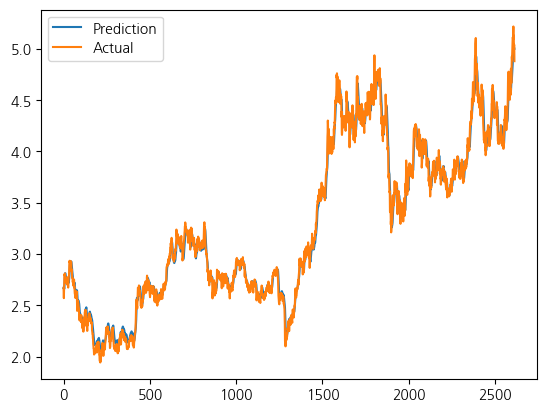

In [ ]:

# 데이터셋 준비
class Cu(Dataset):  # ❶ 클래스 선언
    def __init__(self):
        # ❷ df 데이터 사용
        self.data = df[['시가', '고가', '저가']].values  # 시가, 고가, 저가
        self.label = df['종가'].values  # 종가

    # 사용 가능한 데이터 개수
    def __len__(self):
        return len(self.data) - 30  # ❶ 사용 가능한 배치 개수

    # 데이터와 라벨 반환
    def __getitem__(self, i): # 30일치 주식 데이터를 가지고 그 다음 날의 주식 종가를 예측하려는 목적
        data = self.data[i:i+30]  # ❶ 입력 데이터 30일치
        label = self.label[i+30]  # ❷ 종가 데이터 30일치

        return data, label


# RNN 모델 정의
class RNN(nn.Module): # RNN 클래스는 PyTorch의 nn.Module을 상속받아 RNN 모델을 정의
    def __init__(self):
        super(RNN, self).__init__() # 부모 클래스인 nn.Module의 초기화 메서드

        # ❶ RNN층 정의
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        # input_size=3 : 입력 데이터의 특성 수 (시가, 고가, 저가 3개)
        # hidden_size=8 : 모델의 "기억" 용량

        # ❷ MLP층 정의
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.ReLU()  # 활성화 함수

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)  # ❶ RNN층의 출력

        # ❷ MLP층의 입력으로 사용되게 모양 변경
        x = torch.reshape(x, (x.shape[0], -1))

        # MLP층을 이용해 종가 예측
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # 예측한 종가를 1차원 벡터로 표현
        x = torch.flatten(x)

        return x


# 학습 준비
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RNN().to(device)  # 모델 정의
dataset = Cu()       # 데이터셋 정의

# 배치 크기 설정
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size)  # 배치 크기 32로 설정

# 최적화 정의
optim = Adam(params=model.parameters(), lr=0.0001)  # 최적화 설정

# 학습 루프
for epoch in range(300):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad() # 계산 지우기

        # 초기 은닉 상태
        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        # 모델 예측값
        pred = model(data.type(torch.FloatTensor).to(device), h0)

        # 손실 계산
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()  # 오차 역전파(오차를 뒤로 전달)
        optim.step()     # 최적화 진행(계산된 오차로 파라미터 조정)

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

# 모델 저장
torch.save(model.state_dict(), "./rnn.pth")

# 모델 성능 평가
loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터로더

preds = []  # 예측값 리스트
total_loss = 0

with torch.no_grad():
    # 모델 가중치 불러오기
    model.load_state_dict(torch.load("./rnn.pth", map_location=device))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)  # 초기 은닉 상태 정의

        # 예측값 출력
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())  # 예측값 추가

        # 손실 계산
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        total_loss += loss / len(loader)

# 평균 손실 출력
print(f"Total Loss: {total_loss.item()}")

# 예측값 그래프 출력
plt.plot(preds, label="Prediction")
plt.plot(dataset.label[30:], label="Actual")
plt.legend()
plt.show()

Loss : 모델이 정답에서 얼마나 틀렸는지 를 숫자로 알려주는 값

7일 예측 정확도: 94.27%


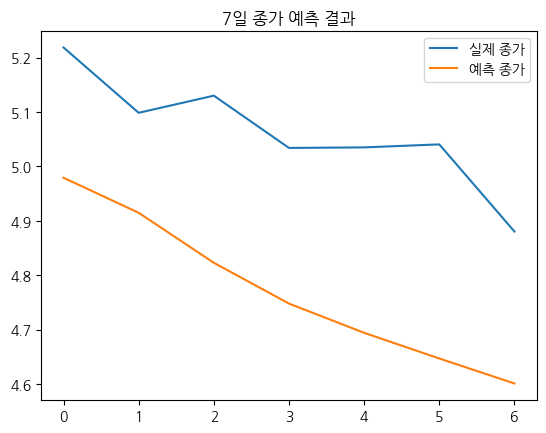

In [ ]:
# 7일 예측 & 정확도 계산
future_preds = []  # 앞으로 7일 동안 예측할 종가
real = []          # 실제 종가 저장
model.eval()       # 평가모드로 전환

# 7일 예측을 위한 마지막 30일 시가/고가/저가 데이터 추출
last_30 = df[['시가', '고가', '저가']].values[-30:]  # numpy 형태
input_seq = torch.tensor(last_30).float().unsqueeze(0).to(device)  # (1, 30, 3)

h0 = torch.zeros(5, 1, 8).to(device)  # 초기 은닉 상태 (레이어 5, 배치 1, 기억 8)

for i in range(7):
    pred = model(input_seq, h0)  # 종가 예측 (1개 숫자)
    future_preds.append(pred.item())  # 예측 결과 저장

    # 다음 입력 시퀀스를 만들기 위해 새로운 데이터 붙이기 (예측한 종가는 입력에 포함 안 됨)
    next_input = df[['시가', '고가', '저가']].values[-30+i+1]  # 다음 날 시가/고가/저가
    input_seq = input_seq.squeeze(0).detach().cpu().numpy()
    input_seq = np.concatenate([input_seq[1:], [next_input]], axis=0)  # 가장 오래된 것 빼고 붙임
    input_seq = torch.tensor(input_seq).float().unsqueeze(0).to(device)

# 실제 7일 종가
real = df['종가'].values[-7:]

# 정확도(Accuracy) 계산 - MSE 대신 예측률 사용
from sklearn.metrics import mean_absolute_percentage_error
acc = 100 - mean_absolute_percentage_error(real, future_preds) * 100
print(f"7일 예측 정확도: {acc:.2f}%")

# 예측 시각화
plt.plot(real, label="실제 종가")
plt.plot(future_preds, label="예측 종가")
plt.title("7일 종가 예측 결과")
plt.legend()
plt.show()
